<h1>Klasifikácia kvality vína pomocou viacvrstvového perceptrónu</h1>
<br>
<h2>Import potrebných knižníc</h2>
<p>Na začiatok si imortujeme potrebné knižnice. V našom projekte budeme potrebovať pandas a numpy pre prácu s dátami, pre vizualizáciu dát použijeme matplotlib a seaborn, ďalej budeme potrebovať MLPClassifier (Multi-layer Perceptron classifier) čiže klasifikátor, ktorý s určitou presnosťou klasifikuje dáta do príslušných skupín. Na štandardizáciu dát použijeme StandardScaler, potom pomocou train_test_split budeme neskôr rozdelovať dáta na trénovacie a testovacie, a na koniec si ešte importujeme classification_report na výpis výsledkov klasifikácie, a GridSearch na nájdenie optimálneho nastavenia klasifikátora.</p>

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

<h2>Príprava datasetu</h2>
<p>Pomocou read_csv si načítame príslušný dataset do padnas dataframeu.</p>

In [29]:
dataset = pd.read_csv("../NS2021_Dicer/wine-dataset.csv")

<p>Ako môžeme vidieť dataset obsahuje nasledujúce parametre:</p>
<p><b>type</b>: typ vína (biele , červené)</p>
<p><b>fixed acidity</b>: stála kyslosť</p>
<p><b>volatile acidity</b>: prchavá kyslosť</p>
<p><b>citric acid</b>: kyselina citrónová</p>
<p><b>residual sugar</b>: zvyškový cukor</p>
<p><b>chlorides</b>: chloridy</p>
<p><b>free sulfur dioxide</b>: voľný oxid siričitý</p>
<p><b>total sulfur dioxide</b>: celkový oxid siričitý</p>
<p><b>density</b>: hustota</p>
<p><b>pH</b>: pH (kyslosť)</p>
<p><b>sulphates</b>: sírany</p>
<p><b>alcohol</b>: alkohol</p>
<p><b>quality</b>: kvalita vína</p>


In [30]:
dataset

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [31]:
dataset['quality'].describe()

count    6497.000000
mean        5.818378
std         0.873255
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64

<p>Kvalita vín je ohodnotená na stupnici 0 až 10. Najlepšie vína sú v datasete ohodnotené deviatimi bodmi a najhoršie tromi.Kedže takéto rozdelenie nie je pre nás ideálne, rozdelíme si ich do troch kategórií:</p>
<p><b>nízka kvalita (0)</b> , <b>stredná kvalita (1)</b> , <b>vysoká kvalita (2)</b></p>

In [32]:
bins= [0, 5.5, 7.5, 10] # vína s hodnotením 3-5 spadajú do kategórie nízka kvalita, 6-7 je stredná a 8-9 vysoká 
labels = [0, 1, 2]
dataset['quality'] = pd.cut(dataset['quality'], bins=bins, labels=labels)

<p>Aby sme mali dataset pripravený na klasifikáciu, musíme ešte doplniť chýbajúce hodnoty pomocou <b>fillna()</b>, takže tieto hodnoty vyplníme priemerom príslušného stĺpcu.<p>

In [33]:
dst = dataset.fillna(dataset.mean())
dst.head(10)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
5,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
6,white,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,1
7,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
8,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
9,white,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,1


<h2>Porozumenie dátam</h2>

<p>Pri použití funkcie <b>describe()</b> môžeme vidieť štatistické údaje datasetu, ako napríklad <b>count</b> (počet prvkov), <b>mean</b> (priemer), <b>std</b> (štandardná odchýlka), <b>min</b> (minimálna hodnota), <b>max</b> (maximálna hodnota). Vďaka tomu môžeme vidieť v akom rozmedzí sa dáta v príslušných stĺpcoch pohybujú.</p>

In [34]:
dst.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801
std,1.295751,0.164548,0.145231,4.757392,0.035031,17.749400,56.521855,0.002999,0.160637,0.148768,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


<p>Zaujímavé poznatky môžeme získať rozdelením parametrov podľa kvality vína. Preto si pomocou funkcie <b>groupby()</b> zoskupíme dáta podľa kvality vína a následne parametre pomocou <b>mean()</b> zpriemerujeme. Môžeme pozorovať určité odlišnosti parametrov vzhľadom na kvalitu vína. Napríklad môžeme vyčítať že čím viac alkoholu víno obsahuje, tým je väčšia pravdepodobnosť že bude mať vyššiu kvalitu.Naopak, čím viac chloridov obsahuje víno tým je väčšia pravdepodobnosť že bude dosahovať nižšiu kvalitu.</p>

In [35]:
means = dst.groupby('quality').mean()
means

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,
0,7.332040,0.397506,0.304182,5.646225,0.064412,29.480495,119.277055,0.995756,3.214398,0.524225,9.873544
1,7.164551,0.306938,0.326809,5.326102,0.051717,30.960281,113.505747,0.994164,3.220478,0.536478,10.807612
2,6.855134,0.291187,0.333889,5.351010,0.040778,34.505051,117.479798,0.992487,3.225354,0.511313,11.691414


<h2>Vizualizácia dát</h2>

<p>Ako prvé si vizualizujeme rozdelenie vín podľa kvality. Ako môžeme videť najmenej vín (len okolo 200) spadá do množiny <b>2</b> (vysoká kvalita), najviac (okolo 3800) do množiny <b>1</b>  (stredná kvalita) a okolo 2400 vín patrí do množiny <b>0</b>  (nízka kvalita). Na vizualizáciu môžeme použit histogram s knižnice seaborn.</p>

<AxesSubplot:>

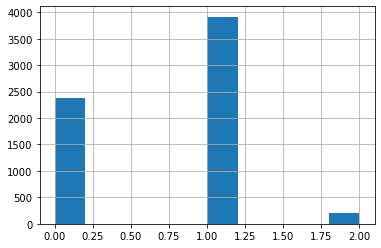

In [36]:
dst['quality'].hist()

<p>Koleráciu parametrov môžeme vizualizovať pomocou teplotnej mapy - heatmap v knižnici seaborn. Teplotná mapa je grafické zobrazenie dát, v ktorom je každá hodnota reprezentovaná farbou určitého spojitého farebného spektra. Farba určuje vzťah medzi príslušnými parametrami. Čím je farba svetlejšia, tým majú parametre silenjší vzťah. Naopak, čím je farba tmavšia, tým je vzťah slabší. Podľa grafu môžeme vidieť že silný vzťah majú napríklad parametre "<b>free sulfur dioxide</b>" a "<b>total sulfur dioxide</b>", naopak slabý vzťah majú napríklad parametre "<b>alcohol</b>" a "<b>density</b>". Svetlé polia na diagonále predstavujú vlastný vzťah parametra, preto sú logicky najsvetlejšie.</p>

<AxesSubplot:>

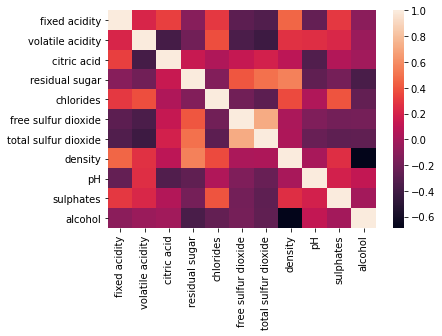

In [37]:
corr = dst.corr()
sns.heatmap(corr, xticklabels = corr.columns.values,
           yticklabels=corr.columns.values)

<p>Vizualizáciu rozdelenia zpriemerovaných paramatetrov podľa kvality vína, ktorú sme si už prichystali do dataframeu vyššie, teraz môžeme zrealizovať pomocou matplotlib subplots. Môžeme videť aké priemerné hodnoty dosahujú parametre v ktorej kvalitovej množine. Z grafov môžeme ľahko vyčítať rôzne informácie. Napríklad že <b>kvalitnejšie</b> vína majú zvyčajne nižšiu <b>stálu kyslosť</b> (fixed acidity), nižšiu <b>prchavú kyslosť</b> (volatile acidity), menej <b>chloridov</b> (chlorides), menšiu <b>hustotu</b> (density), viac <b>kyseliny citrónoovej</b> (citric acid), viac <b>pH</b> (kyslosť), viac <b>alkoholu</b> (alcohol), viac <b>voľného oxidu siričitého</b> (free sulfur dioxide). </p>

Text(0, 0.5, 'PRIEMER alcohol')

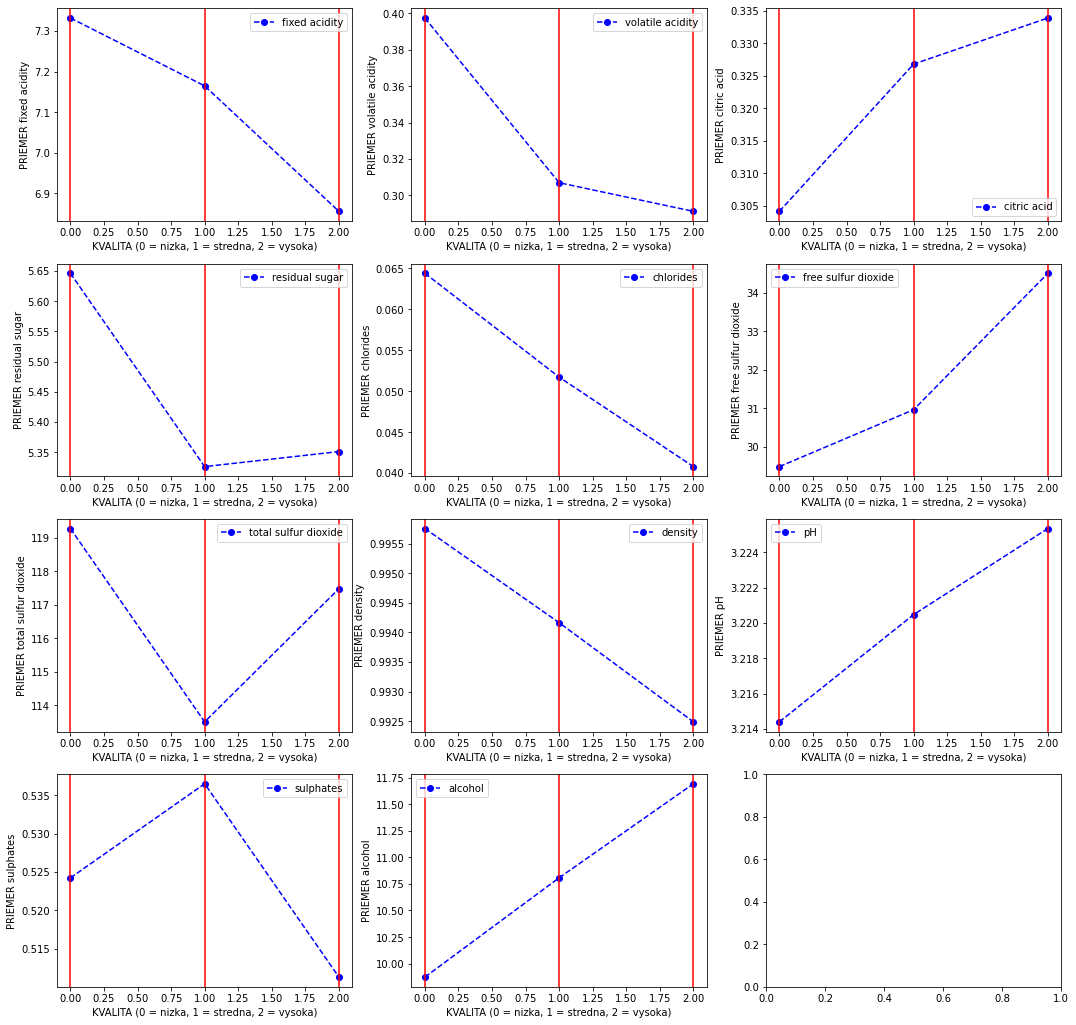

In [120]:
fig, axs = plt.subplots(4,3)
fig.set_figheight(18)
fig.set_figwidth(18)

axs[0,0].plot(np.array(means["fixed acidity"]),'bo',linestyle='--',label="fixed acidity")
axs[0,0].legend(loc="upper right")
axs[0,0].axvline(x=0,color="r")
axs[0,0].axvline(x=1,color="r")
axs[0,0].axvline(x=2,color="r")
axs[0,0].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')
axs[0,0].set_ylabel('PRIEMER fixed acidity')

axs[0,1].plot(np.array(means["volatile acidity"]),'bo',linestyle='--',label="volatile acidity")
axs[0,1].legend(loc="upper right")
axs[0,1].axvline(x=0,color="r")
axs[0,1].axvline(x=1,color="r")
axs[0,1].axvline(x=2,color="r")
axs[0,1].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')
axs[0,1].set_ylabel('PRIEMER volatile acidity')

axs[0,2].plot(np.array(means["citric acid"]),'bo',linestyle='--',label="citric acid")
axs[0,2].legend(loc="lower right")
axs[0,2].axvline(x=0,color="r")
axs[0,2].axvline(x=1,color="r")
axs[0,2].axvline(x=2,color="r")
axs[0,2].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')
axs[0,2].set_ylabel('PRIEMER citric acid')

axs[1,0].plot(np.array(means["residual sugar"]),'bo',linestyle='--',label="residual sugar")
axs[1,0].legend(loc="upper right")
axs[1,0].axvline(x=0,color="r")
axs[1,0].axvline(x=1,color="r")
axs[1,0].axvline(x=2,color="r")
axs[1,0].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')
axs[1,0].set_ylabel('PRIEMER residual sugar')

axs[1,1].plot(np.array(means["chlorides"]),'bo',linestyle='--',label="chlorides")
axs[1,1].legend(loc="upper right")
axs[1,1].axvline(x=0,color="r")
axs[1,1].axvline(x=1,color="r")
axs[1,1].axvline(x=2,color="r")
axs[1,1].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')
axs[1,1].set_ylabel('PRIEMER chlorides')

axs[1,2].plot(np.array(means["free sulfur dioxide"]),'bo',linestyle='--',label="free sulfur dioxide")
axs[1,2].legend(loc="upper left")
axs[1,2].axvline(x=0,color="r")
axs[1,2].axvline(x=1,color="r")
axs[1,2].axvline(x=2,color="r")
axs[1,2].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')
axs[1,2].set_ylabel('PRIEMER free sulfur dioxide')

axs[2,0].plot(np.array(means["total sulfur dioxide"]),'bo',linestyle='--',label="total sulfur dioxide")
axs[2,0].legend(loc="upper right")
axs[2,0].axvline(x=0,color="r")
axs[2,0].axvline(x=1,color="r")
axs[2,0].axvline(x=2,color="r")
axs[2,0].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')
axs[2,0].set_ylabel('PRIEMER total sulfur dioxide')

axs[2,1].plot(np.array(means["density"]),'bo',linestyle='--',label="density")
axs[2,1].legend(loc="upper right")
axs[2,1].axvline(x=0,color="r")
axs[2,1].axvline(x=1,color="r")
axs[2,1].axvline(x=2,color="r")
axs[2,1].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')
axs[2,1].set_ylabel('PRIEMER density')

axs[2,2].plot(np.array(means["pH"]),'bo',linestyle='--',label="pH")
axs[2,2].legend(loc="upper left")
axs[2,2].axvline(x=0,color="r")
axs[2,2].axvline(x=1,color="r")
axs[2,2].axvline(x=2,color="r")
axs[2,2].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')
axs[2,2].set_ylabel('PRIEMER pH')

axs[3,0].plot(np.array(means["sulphates"]),'bo',linestyle='--',label="sulphates")
axs[3,0].legend(loc="upper right")
axs[3,0].axvline(x=0,color="r")
axs[3,0].axvline(x=1,color="r")
axs[3,0].axvline(x=2,color="r")
axs[3,0].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')
axs[3,0].set_ylabel('PRIEMER sulphates')

axs[3,1].plot(np.array(means["alcohol"]),'bo',linestyle='--',label="alcohol")
axs[3,1].legend(loc="upper left")
axs[3,1].axvline(x=0,color="r")
axs[3,1].axvline(x=1,color="r")
axs[3,1].axvline(x=2,color="r")
axs[3,1].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')
axs[3,1].set_ylabel('PRIEMER alcohol')


<h2>Aplikovanie viacvrstvového perceptrónu</h2>
<p>Viacvrstvový perceptrón je neurónová sieť, ktorá je tvorená vzájomne prepojenými neurónmi, ktoré sú
usporiadané do viacerých vrstiev. Ak každý neurón jednej vrstvy vysiela signály na každý neurón nasledujúcej vrstvy
hovoríme o <b>dopredných neurónových sietiach</b>. U dopredných sietí neexistujú spojenia medzi neurónmi tej istej vrstvy, ani medzi neurónmi vzdialených vrstiev. Spojené sú len neuróny susedných vrstiev a to tak, že každý neurón n-tej vrstvy je spojený s každým neurónom n+1-tej vrstvy. </p>
<p>Táto sieť sa pri učení opiera o pravidlo, ktoré nesie názov <b>metóda spätného šírenia chýb</b>. Sieť s ktorou pracujeme má vstupnú vrstvu, tri skryté vrstvy a výstupnú vrstvu. Prepojenia vedú smerom od nižšej vrstvy k vyššej. Približnú schému našej siete môžeme vidieť na obrázku nižšie, pričom počet neurónov na vstupnej vrstve sa rovná počtu vstupných parametrov (11), a v každej skrytej vrstve sa nachádza 100 neurónov, pretože tak sme si to zadefinovali v MLPClassifier triede -> hidden_layer_sizes=(100,100,100).
</p>
<img src="./images/mlp.png"></img>
<b>Algoritmus Back-propagation (metóda spätného šírenia chýb)</b>
<p>Už názov pravidla podľa ktorého sa bude naša sieť učiť nám našepkáva, že budeme
počítať akúsi chybu a tú asi budeme propagovať a to nie v smere dopredu ale späť. Pozor,
nejde o spätné šírenie signálu ale spätné šírenie chyby.Metóda spätného šírenia chyby alebo hovoríme tiež algoritmus back-propagation je najpoužívanejšia metóda pre učenie dopredných viacvrstvových neurónových sietí a používa sa až v 80% aplikácií.</p>
<p>Princíp práce back-propagation si môžeme ukázať na príklade:</p><br>
Výpočet výstupu pre tretí neurón prvej vrstvy:
<img src="./images/bp1.png"></img>
Výpočet výstupu pre prvý neurón druhej vrstvy:
<img src="./images/bp2.png"></img>
Výpočet výstupu pre tretiu vrstvu:
<img src="./images/bp3.png"></img>
Šírenie chyby:
<img src="./images/bp4.png"></img>
<p>Môžeme vidieť že pri učení siete sa pre každý neurón násobia váhy neurónov z predchádzajúcej vrstvy a výstupy neurónov prechádzajúcej vrstvy, ktoré sa nakoniec spočítajú + sa pripočíta bias. Keď získame celkový výstup siete, porovnáme ho s očakávaným výstupom. Ak sú tieto hodnoty totožné, môže sa prejsť na ďalší príklad z tréningovej množiny a
opakovať tento postup. Ak nie, odčítame získaný výstup od očakávaného, čím dostanemetzv. chybový signál, ktorý označujeme delta, a ktorý budeme šíriť po sieti späť. Pomocou chybového signálu môžeme modifikovať pôvodne váhy pre každý neurón a tak postupne </p>

In [39]:
x = dst.drop(columns=['type','quality'])
y = dst['quality']
sc = StandardScaler()
x = sc.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2,random_state=42)

In [40]:
for data in [y_train, y_test]:
    print(data.describe())

count     5197
unique       3
top          1
freq      3115
Name: quality, dtype: int64
count     1300
unique       3
top          1
freq       800
Name: quality, dtype: int64


In [111]:
mlp = MLPClassifier(hidden_layer_sizes=(100,100,100),
                    max_iter=500,
                    early_stopping=True,
                    activation='relu',
                    alpha=0.007,
                    solver='adam',
                    learning_rate='adaptive',
                    verbose = True)

In [112]:
history = mlp.fit(x_train,y_train)

Iteration 1, loss = 0.81441669
Validation score: 0.711538
Iteration 2, loss = 0.67416804
Validation score: 0.748077
Iteration 3, loss = 0.63960680
Validation score: 0.740385
Iteration 4, loss = 0.62270902
Validation score: 0.751923
Iteration 5, loss = 0.61440130
Validation score: 0.751923
Iteration 6, loss = 0.60883344
Validation score: 0.750000
Iteration 7, loss = 0.59911908
Validation score: 0.765385
Iteration 8, loss = 0.59044709
Validation score: 0.759615
Iteration 9, loss = 0.58544742
Validation score: 0.767308
Iteration 10, loss = 0.57969559
Validation score: 0.759615
Iteration 11, loss = 0.57678581
Validation score: 0.765385
Iteration 12, loss = 0.57102680
Validation score: 0.757692
Iteration 13, loss = 0.56463585
Validation score: 0.763462
Iteration 14, loss = 0.55558188
Validation score: 0.755769
Iteration 15, loss = 0.55117109
Validation score: 0.763462
Iteration 16, loss = 0.54609174
Validation score: 0.775000
Iteration 17, loss = 0.54669392
Validation score: 0.769231
Iterat

<h2>Výsledky</h2>

In [118]:
print("MLP accuracy score:",mlp.score(x_train,y_train)*100,"%")

MLP accuracy score: 80.91206465268425 %


In [114]:
pred_mlp= mlp.predict(x_test)
print(classification_report(y_test, pred_mlp))

              precision    recall  f1-score   support

           0       0.75      0.73      0.74       468
           1       0.81      0.86      0.83       800
           2       0.00      0.00      0.00        32

    accuracy                           0.79      1300
   macro avg       0.52      0.53      0.52      1300
weighted avg       0.77      0.79      0.78      1300



Text(0, 0.5, 'Accuracy')

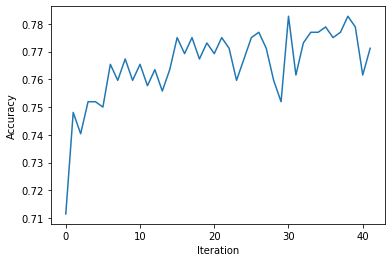

In [116]:
plt.plot(history.validation_scores_)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Error')

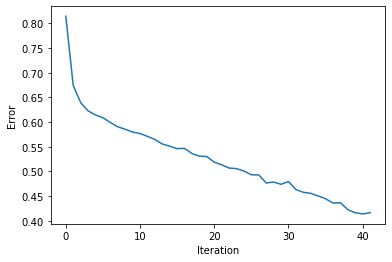

In [115]:
plt.plot(history.loss_curve_)
plt.xlabel("Iteration")
plt.ylabel("Error")